In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
sales = pd.read_csv("archive/bookstore_chain_AB_calgary_2019_2024_dataset/bookstore_sales.csv")

In [37]:
credit = pd.read_csv("archive/bookstore_chain_AB_calgary_2019_2024_dataset/Bookstore Credit Balance Dataset.csv")

In [38]:
payroll = pd.read_csv("archive/bookstore_chain_AB_calgary_2019_2024_dataset/bookstore_payroll.csv")

In [39]:
loans = pd.read_csv("archive/bookstore_chain_AB_calgary_2019_2024_dataset/bookstore_loans.csv")

In [40]:
sales["date"] = pd.to_datetime(sales["date"])

In [41]:
sales_monthly = (
    sales
    .groupby(pd.Grouper(key="date", freq="M"))
    .agg(net_revenue=("net_revenue", "sum"))
    .reset_index()
)

C:\Users\Asier\AppData\Local\Temp\ipykernel_12016\3538324903.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key="date", freq="M"))


In [42]:
credit["date"] = pd.to_datetime(credit["date"])

In [43]:
credit_monthly = (
    credit
    .groupby(pd.Grouper(key="date", freq="M"))
    .agg(
        net_change=("net_change", "sum"),
        balance=("rolling_balance", "last")
    )
    .reset_index()
)

C:\Users\Asier\AppData\Local\Temp\ipykernel_12016\2002439575.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key="date", freq="M"))


In [44]:
payroll["date"] = pd.to_datetime(payroll["pay_period_start"])

In [45]:
payroll["labor_cost"] = (
    payroll["gross_pay"]
    + payroll["cpp_withheld"]
    + payroll["ei_withheld"]
    + payroll["employee_benefits"]
)

In [46]:
payroll_monthly = (
    payroll
    .groupby(pd.Grouper(key="date", freq="M"))
    .agg(
        labor_cost=("labor_cost", "sum"),
        employees=("employee_id", "nunique")
    )
    .reset_index()
)

C:\Users\Asier\AppData\Local\Temp\ipykernel_12016\600585954.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(pd.Grouper(key="date", freq="M"))


In [47]:
pv = pd.merge(
    sales_monthly[["date", "net_revenue"]],
    payroll_monthly[["date", "labor_cost", "employees"]],
    on="date",
    how="inner"
)

In [48]:
pv["payroll_ratio"] = pv["labor_cost"] / pv["net_revenue"]

In [49]:
loans["date"] = pd.to_datetime(loans["quarter_end"])

In [50]:
loans_q = (
    loans
    .groupby("date")
    .agg(
        outstanding=("principal_outstanding", "sum"),
        interest=("interest_accrued", "sum"),
        repayment=("repayment", "sum")
    )
    .reset_index()
)

In [51]:
df_corr = (
    pv
    .merge(
        credit_monthly[["date", "balance"]],
        on="date",
        how="inner"
    )
    .merge(
        loans_q[["date", "outstanding", "interest"]],
        on="date",
        how="left"
    )
)

In [52]:
df_corr.drop(columns="date").corr()

,net_revenue,labor_cost,employees,payroll_ratio,balance,outstanding,interest
net_revenue,1.000000,0.501897,0.582406,0.080205,-0.344416,0.251440,0.525714
labor_cost,0.501897,1.000000,0.862319,0.889164,-0.726186,0.811542,0.909942
employees,0.582406,0.862319,1.000000,0.682717,-0.741985,0.916203,0.912665
payroll_ratio,0.080205,0.889164,0.682717,1.000000,-0.617241,0.887535,0.900337
balance,-0.344416,-0.726186,-0.741985,-0.617241,1.000000,-0.642256,-0.751068
outstanding,0.251440,0.811542,0.916203,0.887535,-0.642256,1.000000,0.941714
interest,0.525714,0.909942,0.912665,0.900337,-0.751068,0.941714,1.000000


In [53]:
df_corr.drop(columns="date").corr(method="spearman")

,net_revenue,labor_cost,employees,payroll_ratio,balance,outstanding,interest
net_revenue,1.000000,0.515885,0.582462,0.133867,-0.339057,0.335664,0.377622
labor_cost,0.515885,1.000000,0.897441,0.887678,-0.720689,0.839161,0.867133
employees,0.582462,0.897441,1.000000,0.759544,-0.783026,0.887725,0.919304
payroll_ratio,0.133867,0.887678,0.759544,1.000000,-0.698405,0.811189,0.839161
balance,-0.339057,-0.720689,-0.783026,-0.698405,1.000000,-0.475524,-0.545455
outstanding,0.335664,0.839161,0.887725,0.811189,-0.475524,1.000000,0.993007
interest,0.377622,0.867133,0.919304,0.839161,-0.545455,0.993007,1.000000


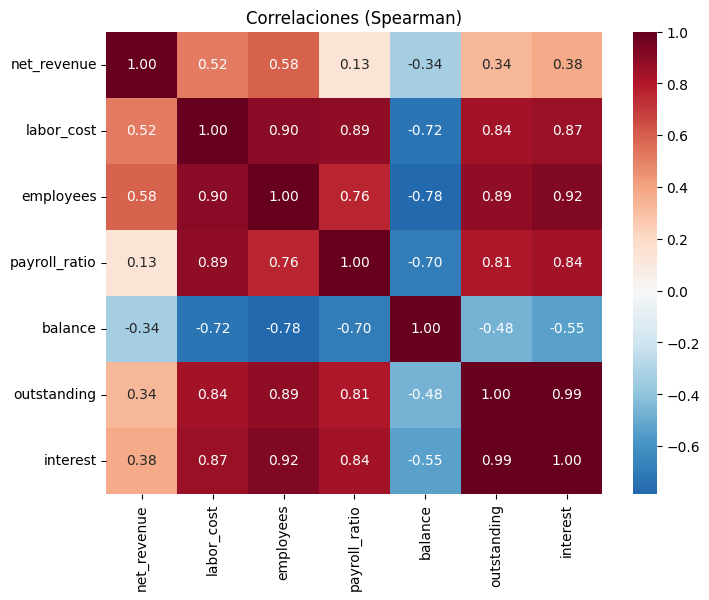

In [54]:
corr = df_corr.drop(columns="date").corr(method="spearman")

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="RdBu_r",
    center=0
)
plt.title("Correlaciones (Spearman)")
plt.show()

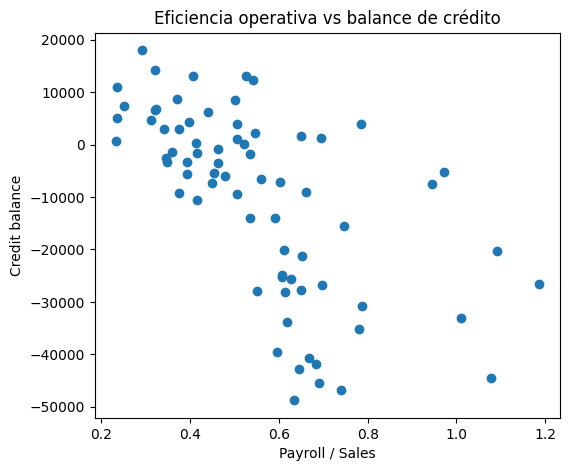

In [ ]:
plt.figure(figsize=(6,5))
plt.scatter(df_corr["payroll_ratio"], df_corr["balance"])
plt.xlabel("Payroll / Sales")
plt.ylabel("Credit balance")
plt.title("Eficiencia operativa vs balance de crédito")
plt.show()

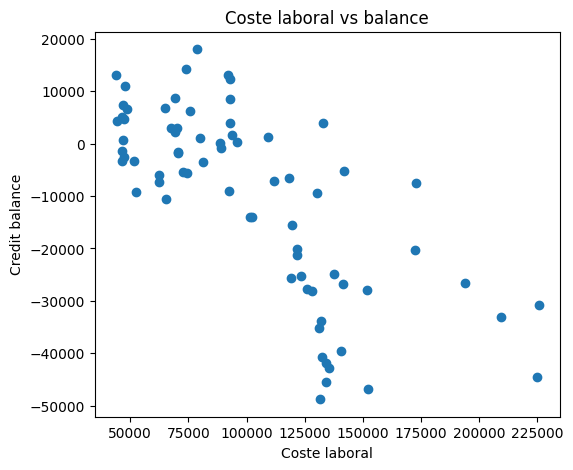

In [56]:
plt.figure(figsize=(6,5))
plt.scatter(df_corr["labor_cost"], df_corr["balance"])
plt.xlabel("Coste laboral")
plt.ylabel("Credit balance")
plt.title("Coste laboral vs balance")
plt.show()

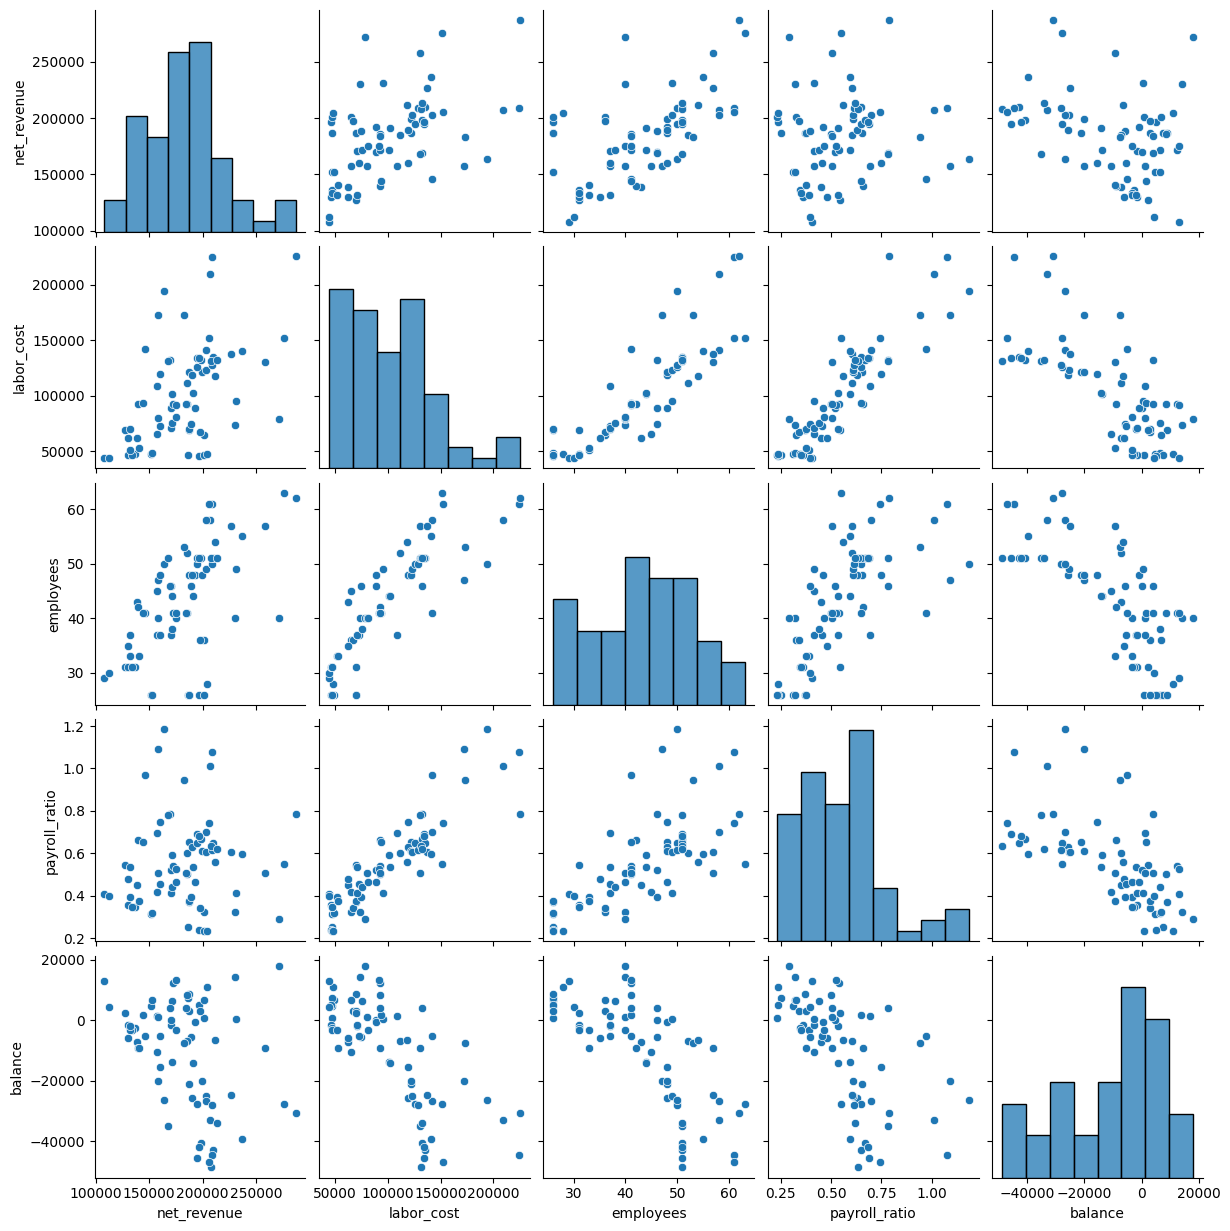

In [57]:
vars_plot = [
    "net_revenue",
    "labor_cost",
    "employees",
    "payroll_ratio",
    "balance"
]

sns.pairplot(df_corr[vars_plot])
plt.show()

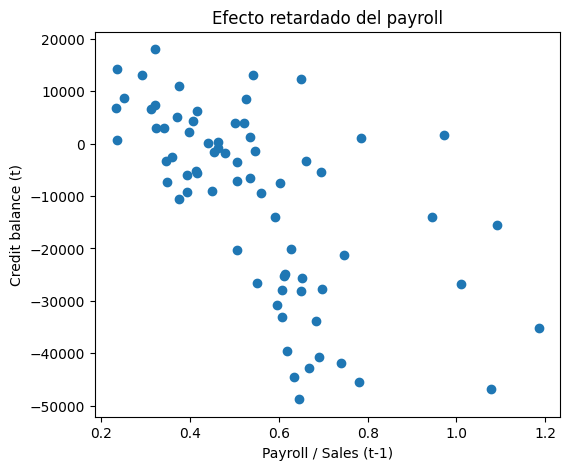

In [58]:
df_corr["payroll_ratio_lag1"] = df_corr["payroll_ratio"].shift(1)

plt.figure(figsize=(6,5))
plt.scatter(df_corr["payroll_ratio_lag1"], df_corr["balance"])
plt.xlabel("Payroll / Sales (t-1)")
plt.ylabel("Credit balance (t)")
plt.title("Efecto retardado del payroll")
plt.show()

El análisis de correlaciones y relaciones bivariantes confirma que el deterioro del balance de crédito está fuertemente asociado al incremento del coste laboral, tanto en términos absolutos como relativos a las ventas. La variable payroll_ratio emerge como el principal indicador de pérdida de eficiencia operativa, mostrando además un efecto retardado sobre la posición financiera del negocio.